# Binary Logistic Regression with PyTorch

## Overview

Logistic regression is a fundamental machine learning algorithm used for binary classification problems. Unlike linear regression that predicts continuous values, logistic regression predicts the probability that an instance belongs to a particular category (0 or 1).

### Key Concepts:
- **Sigmoid Function**: Maps any real number to a value between 0 and 1
- **Linear Combination**: z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
- **Probability**: P(y=1|x) = σ(z) = 1/(1 + e^(-z))
- **Binary Cross-Entropy Loss**: Measures how far predictions are from actual labels

### Learning Objectives:
1. Understand the mathematical foundation of logistic regression
2. Implement logistic regression manually using PyTorch tensors
3. Compare with PyTorch's built-in nn.Module implementation
4. Visualize decision boundaries and training progress

## 1. Setup and Imports


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Data Preparation

We'll create a synthetic medical dataset for binary classification. The data preprocessing steps are crucial:

1. **Standardization**: Centers data around 0 with unit variance
2. **Train-Test Split**: Prevents overfitting by evaluating on unseen data
3. **Tensor Conversion**: PyTorch requires data in tensor format

In [3]:
print("1. Generating synthetic medical data...")
# Simulate medical features (e.g., age, blood pressure, BMI, etc.)
X, y = make_classification(
    n_samples=1000,
    n_features=2,  # 2 features for easy visualization
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    random_state=42,
)

# Standardize features (important for gradient descent)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

print(f"Training samples: {X_train_tensor.shape[0]}")
print(f"Test samples: {X_test_tensor.shape[0]}")
print(f"Features: {X_train_tensor.shape[1]}\n")

1. Generating synthetic medical data...
Training samples: 800
Test samples: 200
Features: 2



In [4]:
X_train_tensor.shape

torch.Size([800, 2])

In [5]:
y_train_tensor.shape

torch.Size([800, 1])

## 3. Manual Implementation

Let's implement logistic regression from scratch to understand the underlying mathematics:

### Mathematical Foundation:

1. **Linear Combination**: z = Xw + b
2. **Sigmoid Function**: σ(z) = 1/(1 + e^(-z))
3. **Binary Cross-Entropy Loss**: L = -[y·log(ŷ) + (1-y)·log(1-ŷ)]
4. **Gradient Descent**: w = w - α·∇L/∇w

### Why Sigmoid?
- Maps any real number to (0,1) range
- Smooth, differentiable function
- S-shaped curve naturally models probability

In [4]:
class LogisticRegressionManual:
    def __init__(self, input_dim):
        # Initialize weights and bias randomly
        self.weights = torch.randn(input_dim, 1, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def sigmoid(self, z):
        """Sigmoid activation function"""
        # Clamp to prevent overflow
        z = torch.clamp(z, -500, 500)
        return 1 / (1 + torch.exp(-z))

    def forward(self, x):
        """Forward pass"""
        # Linear combination: z = X @ w + b
        z = torch.matmul(x, self.weights) + self.bias
        # Apply sigmoid
        return self.sigmoid(z)

    def compute_loss(self, y_pred, y_true):
        """Binary cross-entropy loss"""
        # Prevent log(0) by adding small epsilon
        eps = 1e-15
        y_pred = torch.clamp(y_pred, eps, 1 - eps)

        loss = -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
        return torch.mean(loss)

    def train_step(self, x, y, learning_rate=0.01):
        """One training step"""
        # Forward pass
        y_pred = self.forward(x)

        # Compute loss
        loss = self.compute_loss(y_pred, y)

        # Backward pass
        loss.backward()

        # Update parameters
        with torch.no_grad():
            self.weights -= learning_rate * self.weights.grad
            self.bias -= learning_rate * self.bias.grad

            # Zero gradients for next iteration
            self.weights.grad.zero_()
            self.bias.grad.zero_()

        return loss.item()


### Training the Manual Model

Now let's train our manually implemented logistic regression:

In [5]:
print("Training manual implementation...")
manual_model = LogisticRegressionManual(input_dim=2)
manual_losses = []

for epoch in range(1000):
    loss = manual_model.train_step(X_train_tensor, y_train_tensor, learning_rate=0.1)
    manual_losses.append(loss)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Test manual model
with torch.no_grad():
    manual_predictions = manual_model.forward(X_test_tensor)
    manual_pred_classes = (manual_predictions > 0.5).float()
    manual_accuracy = (manual_pred_classes == y_test_tensor).float().mean()
    print(f"Manual model accuracy: {manual_accuracy:.4f}\n")

Training manual implementation...
Epoch 0, Loss: 0.6636
Epoch 200, Loss: 0.2686
Epoch 400, Loss: 0.2467
Epoch 600, Loss: 0.2398
Epoch 800, Loss: 0.2368
Manual model accuracy: 0.9000



## 4. PyTorch nn.Module Implementation

Now let's implement the same model using PyTorch's built-in components:

### Advantages of nn.Module:
- **Automatic gradient computation**: No need to manually implement backpropagation
- **Built-in optimizers**: SGD, Adam, RMSprop, etc.
- **GPU support**: Easy transfer to GPU with `.cuda()`
- **Model management**: Save/load, parameter counting, etc.

In [ ]:
class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionPyTorch, self).__init__()
        # Linear layer automatically initializes weights and bias
        self.linear = nn.Linear(input_dim, out_features = 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Linear transformation followed by sigmoid
        z = self.linear(x)
        return self.sigmoid(z)


### Training the PyTorch Model

Notice how much cleaner the training loop is with PyTorch's built-in components:

In [8]:
# Initialize model
pytorch_model = LogisticRegressionPyTorch(input_dim=2)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(pytorch_model.parameters(), lr=0.1)

# Training loop
print("Training PyTorch model...")
pytorch_losses = []

for epoch in range(1000):
    # Forward pass
    outputs = pytorch_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters

    pytorch_losses.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Test PyTorch model
pytorch_model.eval()  # Set to evaluation mode
with torch.no_grad():
    pytorch_predictions = pytorch_model(X_test_tensor)
    pytorch_pred_classes = (pytorch_predictions > 0.5).float()
    pytorch_accuracy = (pytorch_pred_classes == y_test_tensor).float().mean()
    print(f"PyTorch model accuracy: {pytorch_accuracy:.4f}\n")

Training PyTorch model...
Epoch 0, Loss: 1.0107
Epoch 200, Loss: 0.2720
Epoch 400, Loss: 0.2475
Epoch 600, Loss: 0.2401
Epoch 800, Loss: 0.2369
PyTorch model accuracy: 0.9000



## 5. Model Comparison

Let's compare both implementations to verify they produce similar results:

In [9]:
print("Model Comparison")
print("-" * 20)
print(f"Manual Implementation Accuracy: {manual_accuracy:.4f}")
print(f"PyTorch Implementation Accuracy: {pytorch_accuracy:.4f}")

# Compare final parameters
print("\nFinal Parameters:")
print("Manual model:")
print(f"  Weights: {manual_model.weights.detach().numpy().flatten()}")
print(f"  Bias: {manual_model.bias.detach().numpy().flatten()}")

print("PyTorch model:")
with torch.no_grad():
    weights = pytorch_model.linear.weight.data.numpy().flatten()
    bias = pytorch_model.linear.bias.data.numpy().flatten()
    print(f"  Weights: {weights}")
    print(f"  Bias: {bias}")

Model Comparison
--------------------
Manual Implementation Accuracy: 0.9000
PyTorch Implementation Accuracy: 0.9000

Final Parameters:
Manual model:
  Weights: [-0.38851106  3.7934768 ]
  Bias: [0.43246585]
PyTorch model:
  Weights: [-0.38539594  3.7838438 ]
  Bias: [0.42853814]


## 6. Visualization

Let's visualize the training progress and decision boundary to better understand how our models learned:

Creating visualizations...


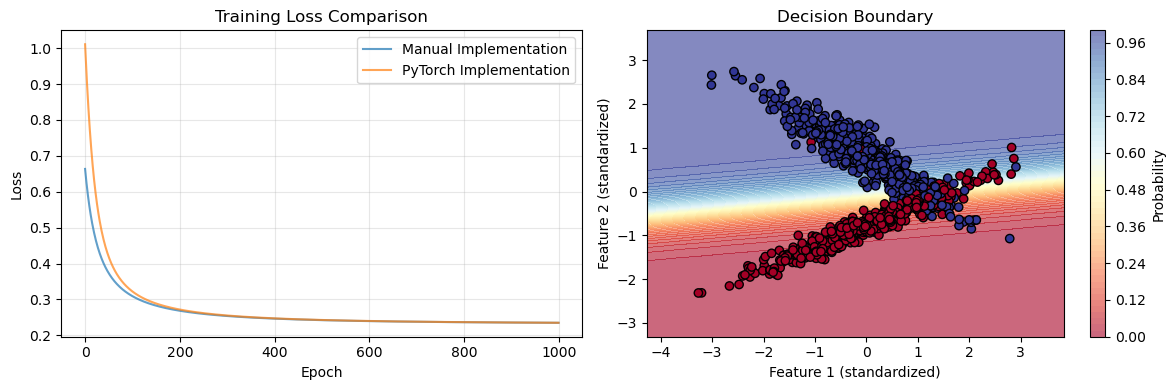

In [10]:
print("Creating visualizations...")

# Plot training losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(manual_losses, label="Manual Implementation", alpha=0.7)
plt.plot(pytorch_losses, label="PyTorch Implementation", alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot decision boundary
plt.subplot(1, 2, 2)
# Create mesh for decision boundary
h = 0.1
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = pytorch_model(mesh_points).numpy()
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap="RdYlBu")
plt.colorbar(label="Probability")
scatter = plt.scatter(
    X_scaled[:, 0], X_scaled[:, 1], c=y, cmap="RdYlBu", edgecolors="black"
)
plt.xlabel("Feature 1 (standardized)")
plt.ylabel("Feature 2 (standardized)")
plt.title("Decision Boundary")

plt.tight_layout()
plt.show()

## 7. Key Takeaways

### What We Learned:

1. **Mathematical Foundation**: 
   - Logistic regression uses the sigmoid function to map linear combinations to probabilities
   - Binary cross-entropy loss measures prediction quality
   - Gradient descent optimizes parameters iteratively

2. **Implementation Comparison**:
   - Manual implementation helps understand the underlying mathematics
   - PyTorch implementation is cleaner and more maintainable
   - Both approaches achieve similar performance

3. **PyTorch Advantages**:
   - Automatic gradient computation
   - Built-in optimizers and loss functions
   - Easy model management and deployment
   - GPU acceleration support

4. **Best Practices**:
   - Always standardize input features
   - Use train/validation/test splits
   - Monitor training loss to detect overfitting
   - Visualize results to validate model behavior

### Next Steps:
- Try different optimizers (Adam, RMSprop)
- Experiment with regularization techniques
- Apply to real-world medical datasets
- Explore multi-class logistic regression

## Summary

✓ Implemented logistic regression manually  
✓ Implemented using PyTorch nn.Module  
✓ Both models achieve similar performance  
✓ PyTorch provides cleaner, more maintainable code  
✓ PyTorch handles gradient computation automatically  

This notebook demonstrates the power of PyTorch for implementing machine learning algorithms while maintaining a deep understanding of the underlying mathematics.